In [28]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime

import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import pickle

In [29]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)

# Shares

## Share:  new and returning users

In [3]:
query = """

select
  date_nk,
  country_sk,
  count(distinct case when user_active_new_returning_nk = 'new' then session_long else null end) as new_users,
  count(distinct session_long) as total_users  
  from ods.fact_user_hydra_browsing_activity 
 where is_panamera = true 
   and date_nk > '2019-02-01'
   and country_sk in ('olx|mea|pk' , 'olx|mea|za' , 'olx|asia|in')
  group by 1,2

 
"""

In [4]:
df_new_and_retur = pd.read_sql_query(query ,engine)
df_new_and_retur.shape

(474, 4)

In [5]:
df_new_and_retur.head()

,date_nk,country_sk,new_users,total_users
0,2019-02-26,olx|mea|za,42247,174534
1,2019-02-02,olx|asia|in,1,58
2,2019-04-01,olx|mea|za,49454,192141
3,2019-02-20,olx|mea|za,44682,185717
4,2019-06-07,olx|mea|za,55151,185826


In [6]:
df_new_and_retur['returning'] = df_new_and_retur['total_users'] - df_new_and_retur['new_users']
df_new_and_retur['percentage_new_user'] = df_new_and_retur['new_users'] / df_new_and_retur['total_users']
df_new_and_retur = df_new_and_retur.sort_values(['date_nk'])
df_new_and_retur.tail()

,date_nk,country_sk,new_users,total_users,returning,percentage_new_user
276,2019-07-08,olx|mea|pk,189974,676505,486531,0.280817
104,2019-07-08,olx|mea|za,66543,205648,139105,0.323577
433,2019-07-09,olx|asia|in,482732,3985998,3503266,0.121107
347,2019-07-09,olx|mea|za,51914,190555,138641,0.272436
111,2019-07-09,olx|mea|pk,135422,619745,484323,0.218512


In [7]:
df_new_and_retur[df_new_and_retur['country_sk'] == 'olx|asia|in'].tail(20)

,date_nk,country_sk,new_users,total_users,returning,percentage_new_user
68,2019-06-20,olx|asia|in,513757,3939326,3425569,0.130417
246,2019-06-21,olx|asia|in,522928,3908020,3385092,0.133809
310,2019-06-22,olx|asia|in,524277,3921072,3396795,0.133708
145,2019-06-23,olx|asia|in,550097,3975417,3425320,0.138375
204,2019-06-24,olx|asia|in,538016,4020926,3482910,0.133804
101,2019-06-25,olx|asia|in,505715,4009677,3503962,0.126124
117,2019-06-26,olx|asia|in,506761,4013754,3506993,0.126256
461,2019-06-27,olx|asia|in,491277,3921686,3430409,0.125272
361,2019-06-28,olx|asia|in,510393,3966256,3455863,0.128684
335,2019-06-29,olx|asia|in,479993,3932981,3452988,0.122043


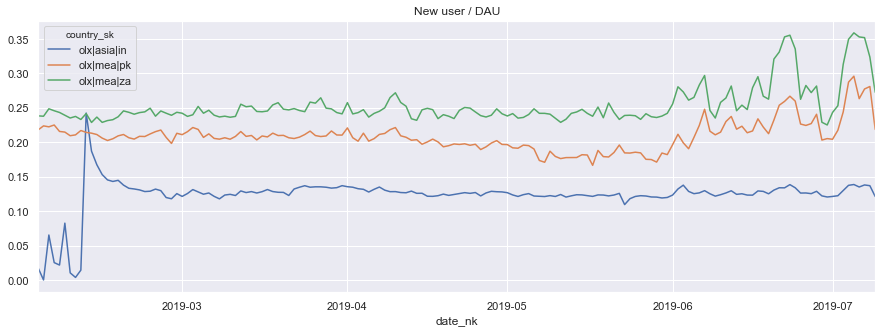

In [8]:
pd.pivot_table(data=df_new_and_retur ,values='percentage_new_user' ,index='date_nk',columns='country_sk').plot(title='New user / DAU' , figsize=(15,5))

FALTARIA ABRIRLO POR CHANNEL!

# Time from first session to login

In [234]:
query1 = """

;drop table if exists first_date_in_app_android;
select
  session_long,
  min(date_event_nk) as first_date_in
  into temp table first_date_in_app_android
   from ods.panameraolx_asia_hydra_ninja_web_last_3_months
  where
     session_long_seq=1
    and channel_sk = 'web|desktop_web'
    and date_event_nk in ('2019-03-01' , '2019-03-02')
 group by 1

;drop table if exists first_reply_in_app_android;
select
  session_long,
  min(date_event_nk) as first_date_reply
  into temp table first_reply_in_app_android
   from ods.panameraolx_asia_hydra_ninja_web_last_3_months
  where
    trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms')
    and channel_sk = 'web|desktop_web'
 group by 1;


select
  f1.session_long,
  f1.first_date_in,
  f2.first_date_reply,
  case when f2.first_date_reply is null then 0 else 1 end as has_made_event,
  case when f2.first_date_reply is null then DATEDIFF(days,f1.first_date_in , CURRENT_TIMESTAMP::timestamp) else datediff(days,first_date_in, first_date_reply)  end as days_to_reply
  from first_date_in_app_android f1
   left join  first_reply_in_app_android f2 on f1.session_long=f2.session_long
 where 
   datediff(days,first_date_in, first_date_reply) >= 0 or datediff(days,first_date_in, first_date_reply) is null
   

"""


In [235]:
df_time_to_reply_android = pd.read_sql_query(query1.replace('%', '%%'), connection_string)

In [236]:
df_time_to_reply_android.head()

,session_long,first_date_in,first_date_reply,has_made_event,days_to_reply
0,16936c5d2efx3d6f7066,2019-03-01,2019-03-01,1,0
1,1693735abc1x325df2ee,2019-03-01,2019-03-01,1,0
2,169377648b0xba2c44b,2019-03-01,2019-03-01,1,0
3,16937775e15x6b023605,2019-03-01,2019-03-01,1,0
4,169378fb27dxd8b5dfb,2019-03-01,2019-03-01,1,0


In [237]:
df_time_to_reply_android['has_made_event'].value_counts()

0    203923
1      8956
Name: has_made_event, dtype: int64

In [238]:
df_time_to_reply_android['days_to_reply_plusone'] = df_time_to_reply_android['days_to_reply'] + 1 

In [239]:
df_time_to_reply_android[df_time_to_reply_android['has_made_event'] == 1].days_to_reply.value_counts().to_excel('C:\\Users\\OLX - Lucas Dresi\\Documents\\Activation\\time_of_response_desktop.xlsx')

Populating the interactive namespace from numpy and matplotlib


[]

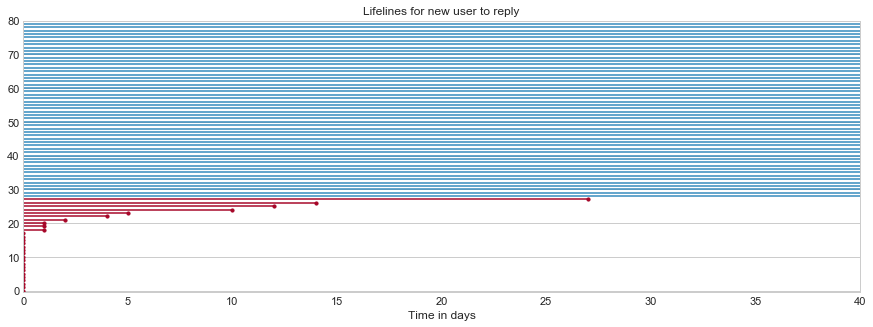

In [213]:
%pylab inline
figsize(15,5)
df_time_to_reply_android_sample = df_time_to_reply_android.sample(n=80)
durations = df_time_to_reply_android_sample.days_to_reply.values
events = df_time_to_reply_android_sample.has_made_event.values

ax = lifelines.plotting.plot_lifetimes(durations=durations,
                                       event_observed=events)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in days")
ax.set_title("Lifelines for new user to reply");
plt.plot()

Median time for reply: inf days after being a new user


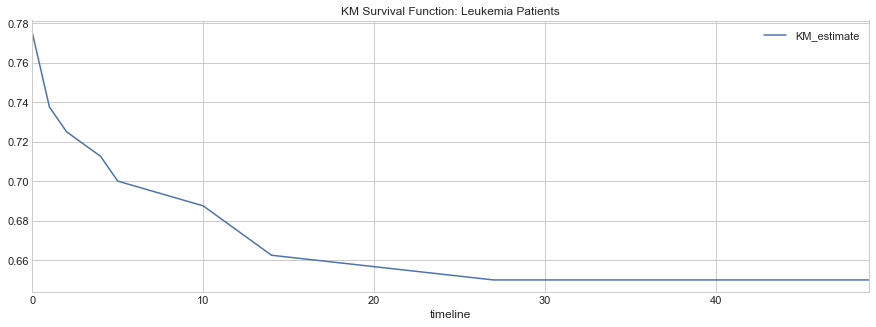

In [217]:
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations, events)

kmf.survival_function_.plot()
# or kmf.survival_function_.plot.line()
plt.title('KM Survival Function: Leukemia Patients');
print(f'Median time for reply: {kmf.median_} days after being a new user')

In [218]:
kmf.predict(1)

0.7375000000000005

In [215]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = df1['hours_to_answer']
C = df1['censored']
kmf.fit(T,C)
%pylab inline
figsize(15,6)

NameError: name 'df1' is not defined

In [ ]:
kmf.plot()

S(t) gives us the probability that the event has not occurred by the time t . In simple words, S(t) gives us the proportion of population with the time to event value more than t.

# Matrix cohort

# DUB / DAU

## Opcion 1 : DUB / DAU new users

In [19]:
query1 = """

WITH verified AS (
    SELECT session_long,date_event_nk
from ods.panameraolx_asia_hydra_ninja_android_last_month
WHERE session_long_seq = 1

 AND (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError' 
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
  group by 1,2
)
SELECT
  date_event_nk,
  COUNT(DISTINCT case when session_long_seq=1 then session_long else null end) as new_users_android,
  COUNT(DISTINCT CASE WHEN trackevent = 'onboarding_show' THEN session_long ELSE NULL END) AS onboarding_show_android,
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_android
  FROM ods.panameraolx_asia_hydra_ninja_android_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1
;

 
"""


query2 = """

WITH verified AS (
    SELECT session_long,date_event_nk
from ods.panameraolx_asia_hydra_ninja_ios_last_month
WHERE session_long_seq = 1
 AND (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError' 
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
  group by 1,2
)
SELECT
  date_event_nk,
  COUNT(DISTINCT CASE WHEN session_long_seq=1 THEN session_long ELSE NULL END) AS new_users_ios,
  COUNT(DISTINCT CASE WHEN trackevent = 'onboarding_show' THEN session_long ELSE NULL END) AS onboarding_show_ios,
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_ios
  FROM ods.panameraolx_asia_hydra_ninja_ios_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1

 
"""


query3 = """

WITH verified AS (
    SELECT session_long,date_event_nk
from ods.panameraolx_asia_hydra_ninja_web_last_month
WHERE session_long_seq = 1
 AND (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError' 
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
  group by 1,2
)
SELECT
  date_event_nk,
  COUNT(DISTINCT CASE WHEN session_long_seq=1 THEN session_long ELSE NULL END) AS new_users_web,  
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_web
  FROM ods.panameraolx_asia_hydra_ninja_web_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1

 
"""

In [20]:
%%time
df_new_repliers_android = pd.read_sql_query(query1.replace('%', '%%'), connection_string)
df_new_repliers_ios = pd.read_sql_query(query2.replace('%', '%%'), connection_string)
df_new_repliers_web = pd.read_sql_query(query3.replace('%', '%%'), connection_string)

Wall time: 3min 36s


In [22]:
df_new_repliers_android['DUB_/_DAU_android'] = df_new_repliers_android['repliers_android'] / df_new_repliers_android['new_users_android']
df_new_repliers_ios['DUB_/_DAU_ios'] = df_new_repliers_ios['repliers_ios'] / df_new_repliers_ios['new_users_ios']
df_new_repliers_web['DUB_/_DAU_web'] = df_new_repliers_web['repliers_web'] / df_new_repliers_web['new_users_web']

In [24]:
df_new_repliers = pd.merge(df_new_repliers_android ,df_new_repliers_ios , how='inner' , on='date_event_nk')
df_new_repliers = pd.merge(df_new_repliers ,df_new_repliers_web , how='inner' , on='date_event_nk')

In [30]:
df_new_repliers['new_users'] = df_new_repliers['new_users_android'] + df_new_repliers['new_users_ios'] +  df_new_repliers['new_users_web'] 
df_new_repliers['new_users_repliers'] = df_new_repliers['repliers_android'] + df_new_repliers['repliers_ios'] +  df_new_repliers['repliers_web'] 
df_new_repliers['DUB/DAU_new'] = df_new_repliers['new_users_repliers'] / df_new_repliers['new_users'] 

In [31]:
df_new_repliers.head()

,date_event_nk,new_users_android,onboarding_show_android,repliers_android,DUB_/_DAU_android,new_users_ios,onboarding_show_ios,repliers_ios,DUB_/_DAU_ios,new_users_web,repliers_web,DUB_/_DAU_web,new_users,new_users_repliers,DUB_/_DAU,DUB/DAU_new
0,2019-05-18,243871,190356,54228,0.222363,13205,8452,2474,0.187353,599701,13410,0.022361,856777,70112,0.081832,0.081832
1,2019-05-11,246660,192433,54983,0.222910,12989,8203,2499,0.192394,604429,14070,0.023278,864078,71552,0.082807,0.082807
2,2019-05-16,241306,189411,54520,0.225937,12861,8120,2432,0.189099,610007,13679,0.022424,864174,70631,0.081732,0.081732
3,2019-05-13,239317,185796,52784,0.220561,12649,7925,2338,0.184837,622031,13326,0.021423,873997,68448,0.078316,0.078316
4,2019-05-06,234015,182330,50726,0.216764,12861,7968,2339,0.181868,596434,13350,0.022383,843310,66415,0.078755,0.078755


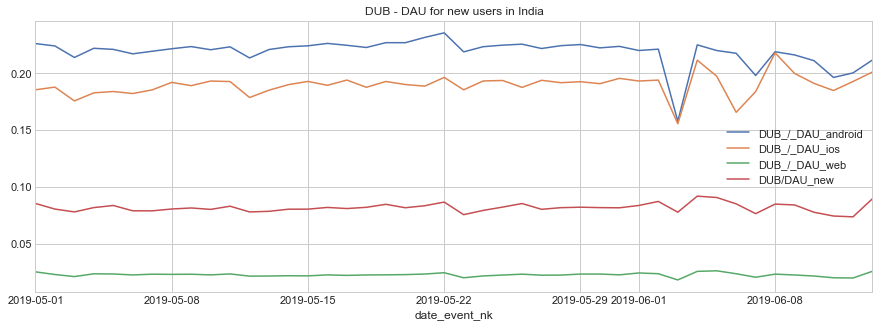

In [38]:
df_new_to_reply = df_new_repliers[['date_event_nk', 'DUB_/_DAU_android' , 'DUB_/_DAU_ios' , 'DUB_/_DAU_web' , 'DUB/DAU_new']]
df_new_to_reply = df_new_to_reply.set_index('date_event_nk')
df_new_to_reply.plot(title='DUB - DAU for new users in India'  ,figsize=(15,5))

In [2]:
!conda install -c conda-forge jupyter_contrib_nbextensions
y

failed

CondaError: KeyboardInterrupt



NameError: name 'y' is not defined

## Opcion 1 : DUB / DAU returning users

In [64]:
query1 = """

WITH verified AS (
    SELECT session_long,date_event_nk,min(session_long_seq)
 from ods.panameraolx_asia_hydra_ninja_android_last_month
 
 WHERE (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError' 
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
        
  group by 1,2
  having min(session_long_seq) > 1
)
SELECT
  date_event_nk,
  COUNT(DISTINCT session_long) as returning_users_android,
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_android
  FROM ds.poanameraolx_asia_hydra_ninja_android_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1
;

"""


query2 = """

WITH verified AS (
    SELECT session_long,date_event_nk,min(session_long_seq)
 from ods.panameraolx_asia_hydra_ninja_ios_last_month
 
  WHERE (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError'
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
 
  group by 1,2
  having min(session_long_seq) > 1
)
SELECT
  date_event_nk,
  COUNT(DISTINCT session_long) as returning_users_ios,
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_ios
  FROM ods.panameraolx_asia_hydra_ninja_ios_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1
;

 
"""


query3 = """

WITH verified AS (
    SELECT session_long,date_event_nk,min(session_long_seq)
 from ods.panameraolx_asia_hydra_ninja_web_last_month
 
  WHERE (trackevent  NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis'
, 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show'
, 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount'
,'test_assignment', 'google_play_services'
,'test_impression','test_discovered','appOpen', 'fetchTestDefinitionsError' 
, 'insertActiveTestListError', 'updateActiveTestError', 'deleteAllActiveTestsError'
, 'getActiveTestListError', 'getExistingActiveTestListError', 'insertDiscoveredTestListError'
, 'getDiscoveredTestListError', 'getChangedDiscoveredTestListError', 'deleteDiscoveredTestsThatAreActiveError'
, 'deleteExpiredDiscoveredTestsError', 'setNotExecutedError', 'contextIsNull'
, 'contextIsNotInstanceOfApplication', 'configIsNull', 'fetchTestDefinitionsError'
, 'test_assignment', 'test_impression', 'test_discovered') OR
        trackevent NOT ILIKE 'b2c%')
        
  group by 1,2
  having min(session_long_seq) > 1
)
SELECT
  date_event_nk,
  COUNT(DISTINCT session_long) as returning_users_web,
  COUNT(DISTINCT CASE WHEN trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms') THEN session_long ELSE NULL END) AS repliers_web
  FROM ods.panameraolx_asia_hydra_ninja_web_last_month
JOIN verified USING (session_long,date_event_nk)
group by 1
;

"""

In [65]:
%%time
df_retur_repliers_android = pd.read_sql_query(query1.replace('%', '%%'), connection_string)
df_retur_repliers_ios = pd.read_sql_query(query2.replace('%', '%%'), connection_string)
df_retur_repliers_web = pd.read_sql_query(query3.replace('%', '%%'), connection_string)

Wall time: 12min 2s


In [66]:
df_retur_repliers_android.sort_values(['date_event_nk']).tail()

,date_event_nk,returning_users_android,repliers_android
31,2019-06-10,5572196,621710
38,2019-06-11,5672373,604935
41,2019-06-12,5641322,603295
16,2019-06-13,5075395,586495
0,2019-06-14,358035,34094


In [67]:
df_retur_repliers_android['DUB_/_DAU_android'] = df_retur_repliers_android['repliers_android'] / df_retur_repliers_android['returning_users_android']
df_retur_repliers_ios['DUB_/_DAU_ios'] = df_retur_repliers_ios['repliers_ios'] / df_retur_repliers_ios['returning_users_ios']
df_retur_repliers_web['DUB_/_DAU_web'] = df_retur_repliers_web['repliers_web'] / df_retur_repliers_web['returning_users_web']

In [68]:
df_retur_repliers = pd.merge(df_retur_repliers_android ,df_retur_repliers_ios , how='inner' , on='date_event_nk')
df_retur_repliers = pd.merge(df_retur_repliers ,df_retur_repliers_web , how='inner' , on='date_event_nk')

In [69]:
df_retur_repliers['returning_users'] = df_retur_repliers['returning_users_android'] + df_retur_repliers['returning_users_ios'] +  df_retur_repliers['returning_users_web'] 
df_retur_repliers['returning_users_repliers'] = df_retur_repliers['repliers_android'] + df_retur_repliers['repliers_ios'] +  df_retur_repliers['repliers_web'] 
df_retur_repliers['DUB/DAU_returning'] = df_retur_repliers['returning_users_repliers'] / df_retur_repliers['returning_users'] 

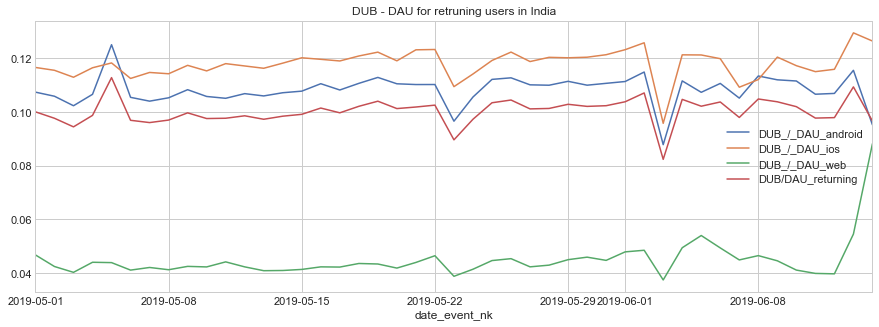

In [70]:
df_retur_to_reply = df_retur_repliers[['date_event_nk', 'DUB_/_DAU_android' , 'DUB_/_DAU_ios' , 'DUB_/_DAU_web' , 'DUB/DAU_returning']]
df_retur_to_reply = df_retur_to_reply.set_index('date_event_nk')
df_retur_to_reply.plot(title='DUB - DAU for retruning users in India'  ,figsize=(15,5))

## Opcion 2 : DUB / DAU new users

In [14]:
query = """

drop table if exists dau_new;
select
  date_nk,
  count(distinct session_long) as new_dau
   into temp dau_new
   from ods.fact_user_hydra_browsing_activity
   --  left join (select session_long,user_sk,date_nk from ods.fact_user_hydra_browsing_activity where user_sk!='unknown' and is_panamera = true and country_sk in ('olx|mea|pk' , 'olx|mea|za' , 'olx|asia|in') and date_nk = '2019-06-11')
 where
   is_panamera = true
    and date_nk >= '2019-05-01'
    and country_sk in ('olx|asia|in')
    and user_active_new_returning_nk = 'new'
group by 1
order by 1

;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
and user_sk != 'unknown'
and date_nk >= '2019-05-01'
 group by 1,2,3

;drop table if exists repliess;
select
   date_sent_nk,
   count(distinct panamera_user_sk) as new_repliers
  into temp repliess
  from ods.fact_replies f1
    inner join new_users_label f2 on f1.panamera_user_sk=f2.user_sk and f1.date_sent_nk=f2.date_nk
    where country_sk = 'olx|asia|in'
  and reply_num = 1
  and date_sent_nk >= '2019-05-01'
group by 1;


select
  f1.date_nk,
  f1.new_dau,
  f2.new_repliers
   from dau_new f1
  inner join repliess f2 on f1.date_nk=f2.date_sent_nk
order by 1
    
 
"""

In [15]:
df_news_to_reply = pd.read_sql_query(query ,engine)

In [16]:
df_news_to_reply.head(40)

,date_nk,new_dau,new_repliers
0,2019-05-01,477561,73898
1,2019-05-02,460631,70323
2,2019-05-03,445650,66558
3,2019-05-04,455528,69442
4,2019-05-05,460759,70618
5,2019-05-06,448982,66956
6,2019-05-07,446197,66638
7,2019-05-08,446799,67906
8,2019-05-09,457695,69497
9,2019-05-10,446982,67392


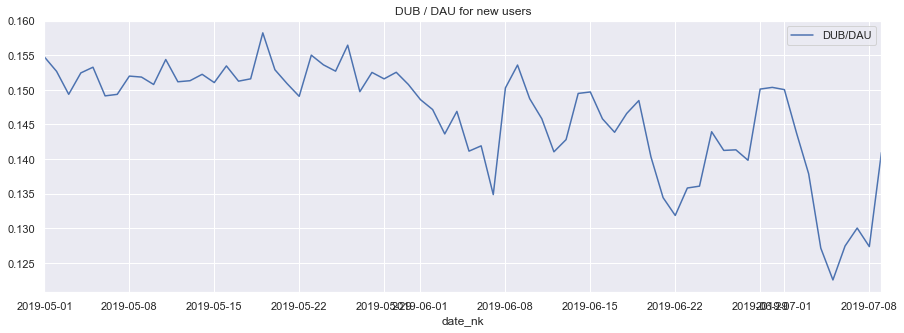

In [17]:
df_news_to_reply['DUB/DAU'] = df_news_to_reply['new_repliers'] / df_news_to_reply['new_dau']
df_news_to_reply = df_news_to_reply.set_index('date_nk')
df_news_to_reply = df_news_to_reply[['DUB/DAU']]
df_news_to_reply.plot(figsize=(15,5) , title='DUB / DAU for new users')

In [18]:
df_news_to_reply['DUB/DAU'].mean()

0.1462992681493174

## Opcion 2 : DUB / DAU returning users

In [22]:
query = """

drop table if exists dau_new_and_retur;
select
  date_nk,
  count(distinct case when user_active_new_returning_nk = 'new' then session_long else null end) as new_users,
  count(distinct session_long) as total_users  
  into temp table dau_new_and_retur
  from ods.fact_user_hydra_browsing_activity 
 where is_panamera = true 
   and date_nk >= '2019-05-01'
   and country_sk = 'olx|asia|in'
  group by 1


;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_sk != 'unknown'
and date_nk >= '2019-05-01'
and user_active_new_returning_nk = 'new'
 group by 1,2,3


;drop table if exists repliess;
select
   date_sent_nk,
   count(distinct panamera_user_sk) as returning_repliers
  into temp repliess
  from ods.fact_replies f1
    left join new_users_label f2 on f1.panamera_user_sk=f2.user_sk and f1.date_sent_nk=f2.date_nk
    where country_sk = 'olx|asia|in'
 and reply_num = 1
 and date_sent_nk >= '2019-05-01'
 and f2.user_sk is null
group by 1;

select
 date_nk,
 f1.total_users - f1.new_users as returning_user,
 f2.returning_repliers
  from dau_new_and_retur f1
   inner join repliess f2 on f1.date_nk=f2.date_sent_nk
order by 1

"""

In [23]:
df_returning_to_reply = pd.read_sql_query(query ,engine)

In [24]:
df_returning_to_reply.sort_values(['date_nk']).head(50)

,date_nk,returning_user,returning_repliers
0,2019-05-01,3292534,662354
1,2019-05-02,3272462,646647
2,2019-05-03,3230965,616324
3,2019-05-04,3224294,640090
4,2019-05-05,3215541,648195
5,2019-05-06,3236100,623548
6,2019-05-07,3225953,632785
7,2019-05-08,3242738,638517
8,2019-05-09,3281590,655938
9,2019-05-10,3241376,638354


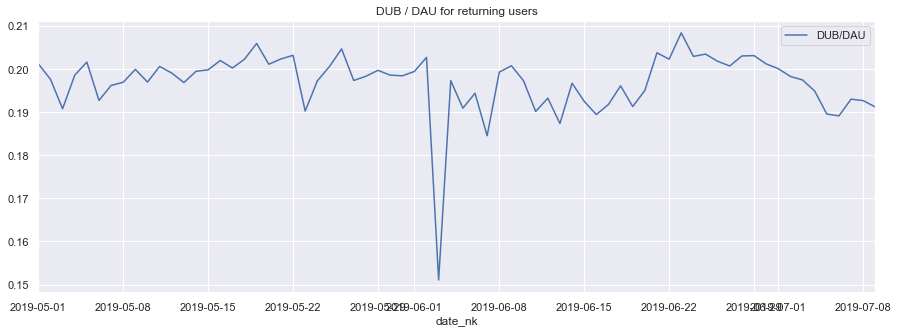

In [25]:
df_returning_to_reply['DUB/DAU'] = df_returning_to_reply['returning_repliers'] / df_returning_to_reply['returning_user']
df_returning_to_reply = df_returning_to_reply.set_index('date_nk')
df_returning_to_reply = df_returning_to_reply[['DUB/DAU']]
df_returning_to_reply.plot(figsize=(15,5) , title='DUB / DAU for returning users')

## Opcion 2: DUB / DAU returning users activate it or not

In [ ]:
query = """

drop table if exists dau_new_and_retur;
select
  date_nk,
  count(distinct case when user_active_new_returning_nk = 'new' then session_long else null end) as new_users,
  count(distinct session_long) as total_users
  into temp table dau_new_and_retur
  from ods.fact_user_hydra_browsing_activity
 where is_panamera = true
   and date_nk >= '2019-06-01'
   and country_sk = 'olx|asia|in'
  group by 1


;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_sk != 'unknown'
and date_nk >= '2019-06-01'
and user_active_new_returning_nk = 'new'
 group by 1,2,3

;drop table if exists number_of_reply;
select
  panamera_user_sk,
  date_sent_nk
  into temp table number_of_reply
 from ods.fact_replies
 where
   country_sk like '%in%'
 and reply_num =1
  group by 1,2

;drop table if exists numero_de_replies;
select
  panamera_user_sk,
  date_sent_nk,
  row_number()over(partition by panamera_user_sk order by date_sent_nk) as number_of_replies
  into temp table numero_de_replies
from number_of_reply

;drop table if exists repliess;
select
   date_sent_nk,
   case when f1.number_of_replies=1 then 'not_activated' else 'already_activate' end as activado_o_no,
   count(distinct panamera_user_sk) as returning_repliers
  into temp repliess
  from numero_de_replies f1
    left join new_users_label f2 on f1.panamera_user_sk=f2.user_sk and f1.date_sent_nk=f2.date_nk
    where
      date_sent_nk >= '2019-05-01'
  and f2.user_sk is null
group by 1,2;

select
 date_nk,
 f2.activado_o_no,
 f1.total_users - f1.new_users as returning_user,
 f2.returning_repliers
  from dau_new_and_retur f1
   inner join repliess f2 on f1.date_nk=f2.date_sent_nk
order by 1

"""

In [ ]:
df_returning_to_reply_by_activate = pd.read_sql_query(query ,engine)

In [ ]:
df_returning_to_reply_by_activate.head()

In [ ]:
df_returning_to_reply_by_activate['percentage_of_returning'] = df_returning_to_reply_by_activate['returning_repliers'] / df_returning_to_reply_by_activate['returning_user']
df_returning_to_reply_by_activate_plot = df_returning_to_reply_by_activate.set_index('date_nk')
df_returning_to_reply_by_activate_plot = df_returning_to_reply_by_activate_plot[['activado_o_no' , 'percentage_of_returning']]
df_returning_to_reply_by_activate_plot.pivot_table(index=df_returning_to_reply_by_activate_plot.index , columns='activado_o_no',values='percentage_of_returning').plot(figsize=(15,5))

In [ ]:
df_returning_to_reply_by_activate['total_repliers'] = df_returning_to_reply_by_activate.groupby(['date_nk'])['returning_repliers'].transform('sum')
df_returning_to_reply_by_activate['percentage_of_repliers_activate'] = df_returning_to_reply_by_activate['returning_repliers'] / df_returning_to_reply_by_activate['total_repliers'] 

## Check of replies

In [89]:
query = """


select
   date_sent_nk,
   count(distinct panamera_user_sk) as repliers
  from ods.fact_replies f1
    where country_sk = 'olx|asia|in'
 and reply_num = 1
 and date_sent_nk >= '2019-05-01'
group by 1
order by 1

"""

In [90]:
%%time
replies = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 17.4 s


In [91]:
replies.head()

,date_sent_nk,repliers
0,2019-05-12,695874
1,2019-05-11,729354
2,2019-06-09,731536
3,2019-05-27,742260
4,2019-05-13,715657


## Opcion 2: DUB/DAU new users for apps

In [30]:
query = """

drop table if exists dau_new;
select
  date_nk,
  count(distinct session_long) as new_dau
   into temp dau_new
   from ods.fact_user_hydra_browsing_activity
   --  left join (select session_long,user_sk,date_nk from ods.fact_user_hydra_browsing_activity where user_sk!='unknown' and is_panamera = true and country_sk in ('olx|mea|pk' , 'olx|mea|za' , 'olx|asia|in') and date_nk = '2019-06-11')
 where
   is_panamera = true
    and date_nk >= '2019-05-01'
    and country_sk in ('olx|asia|in')
    and user_active_new_returning_nk = 'new'
    and channel_sk similar to ('%%android%%|%%ios%%')
group by 1
order by 1

;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
and user_sk != 'unknown'
and date_nk >= '2019-05-01'
and channel_sk similar to ('%%android%%|%%ios%%')
 group by 1,2,3

;drop table if exists repliess;
select
   date_sent_nk,
   count(distinct panamera_user_sk) as new_repliers
  into temp repliess
  from ods.fact_replies f1
    inner join new_users_label f2 on f1.panamera_user_sk=f2.user_sk and f1.date_sent_nk=f2.date_nk
    where country_sk = 'olx|asia|in'
  and reply_num = 1
  and date_sent_nk >= '2019-05-01'
group by 1;


select
  f1.date_nk,
  f1.new_dau,
  f2.new_repliers
   from dau_new f1
  inner join repliess f2 on f1.date_nk=f2.date_sent_nk
order by 1

 
"""

In [31]:
df_news_to_reply_android = pd.read_sql_query(query.replace('%' , '%%') ,engine)

In [32]:
df_news_to_reply_android.head()

,date_nk,new_dau,new_repliers
0,2019-05-01,205064,57042
1,2019-05-02,196995,54487
2,2019-05-03,198774,52663
3,2019-05-04,197389,53925
4,2019-05-05,204389,55647


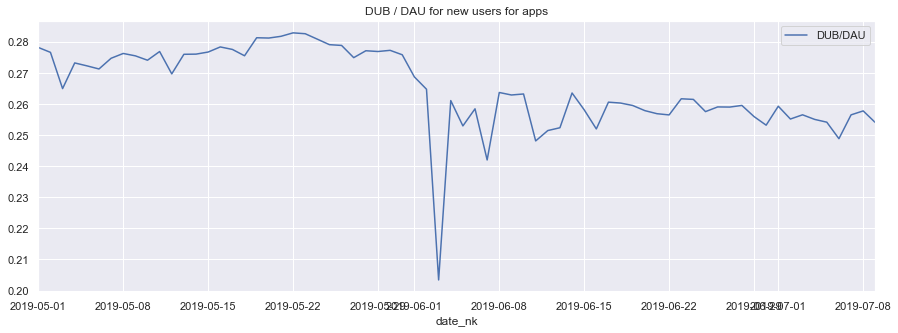

In [33]:
df_news_to_reply_android['DUB/DAU'] = df_news_to_reply_android['new_repliers'] / df_news_to_reply_android['new_dau']
df_news_to_reply_android = df_news_to_reply_android.set_index('date_nk')
df_news_to_reply_android = df_news_to_reply_android[['DUB/DAU']]
df_news_to_reply_android.plot(figsize=(15,5) , title='DUB / DAU for new users for apps')

## DUB/DAU new users for PWA web

In [77]:
query = """

drop table if exists dau_new;
select
  date_nk,
  count(distinct session_long) as new_dau
   into temp dau_new
   from ods.fact_user_hydra_browsing_activity
   --  left join (select session_long,user_sk,date_nk from ods.fact_user_hydra_browsing_activity where user_sk!='unknown' and is_panamera = true and country_sk in ('olx|mea|pk' , 'olx|mea|za' , 'olx|asia|in') and date_nk = '2019-06-11')
 where
   is_panamera = true
    and date_nk >= '2019-05-01'
    and country_sk in ('olx|asia|in')
    and user_active_new_returning_nk = 'new'
    and channel_sk similar to ('%%mobile%%|%%desktop%%')
group by 1
order by 1

;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
and user_sk != 'unknown'
and date_nk >= '2019-05-01'
and channel_sk similar to ('%%mobile%%|%%desktop%%')
 group by 1,2,3

;drop table if exists repliess;
select
   date_sent_nk,
   count(distinct panamera_user_sk) as new_repliers
  into temp repliess
  from ods.fact_replies f1
    inner join new_users_label f2 on f1.panamera_user_sk=f2.user_sk and f1.date_sent_nk=f2.date_nk
    where country_sk = 'olx|asia|in'
  and reply_num = 1
  and date_sent_nk >= '2019-05-01'
group by 1;


select
  f1.date_nk,
  f1.new_dau,
  f2.new_repliers
   from dau_new f1
  inner join repliess f2 on f1.date_nk=f2.date_sent_nk
order by 1

 
"""

In [78]:
%%time
df_news_to_reply_mobile = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 3min 43s


In [79]:
df_news_to_reply_mobile.head()

,date_nk,new_dau,new_repliers
0,2019-05-01,477561,73898
1,2019-05-02,460631,70323
2,2019-05-03,445650,66558
3,2019-05-04,455528,69442
4,2019-05-05,460759,70618


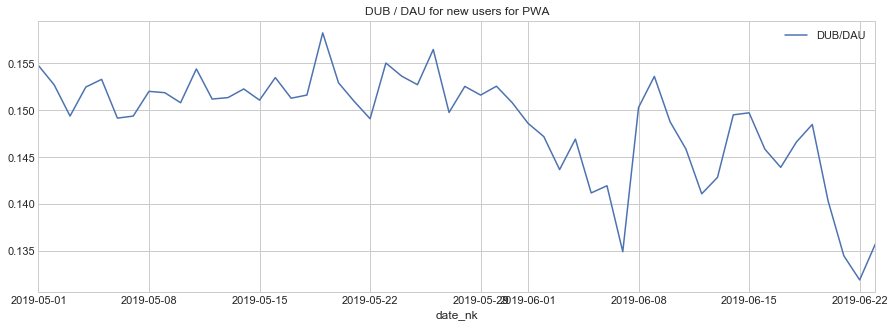

In [80]:
df_news_to_reply_mobile['DUB/DAU'] = df_news_to_reply_mobile['new_repliers'] / df_news_to_reply_mobile['new_dau']
df_news_to_reply_mobile = df_news_to_reply_mobile.set_index('date_nk')
df_news_to_reply_mobile = df_news_to_reply_mobile[['DUB/DAU']]
df_news_to_reply_mobile.plot(figsize=(15,5) , title='DUB / DAU for new users for PWA')

# DUB / Starters of home,browse and search new users

In [103]:
query = """

drop table if exists new_users_label;
select
  date_nk,
  session_long
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
and date_nk >= '2019-04-01'
 group by 1,2;

select
  a.date_nk,
  (case when search_string notnull then 'Search'
        when a.category_sk!='unknown' and search_string isnull then 'Browse'
        when a.category_sk='unknown' and search_string isnull  then 'Home'  end) as Flow_new,

  count(distinct a.session_long_sk) starters_new_users
, count(distinct case when a.num_ads_with_adviews>'0' then a.session_long_sk end) adviewers_new_users
, count(distinct case when ((a.num_ads_with_item_chat_tap_send_1st_reply+a.num_ads_with_item_chat_tap_send_offer)>'0' then session_long_sk else null end) as repliers_chat
, count(distinct case when ((a.num_ads_with_item_tap_call)>'0'  then session_long_sk else null end) as replier_call

from ods.fact_resultset_performance a
  inner join new_users_label f1 on f1.session_long=split_part(session_long_sk , '|' , 7) and f1.date_nk=a.date_nk
 where a.country_sk='olx|asia|in'
and a.date_nk >= '2019-04-01'
group by a.date_nk, Flow_new
order by 1;

"""

In [104]:
%%time
starters_to_dub = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 9min 33s


In [173]:
starters_to_dub.to_excel('C:\\Users\\OLX - Lucas Dresi\\Documents\\Activation\\activation.xlsx')

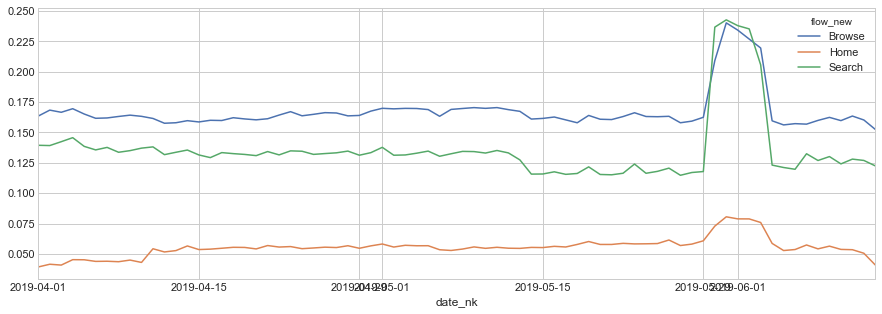

In [121]:
starters_to_dub['new_replier_to_starters_new'] = starters_to_dub['repliers_new_users'] / starters_to_dub['starters_new_users'] 
starters_to_dub.pivot_table(index='date_nk' , columns='flow_new' , values='new_replier_to_starters_new').plot(figsize=(15,5) , label='DUB / Starters of home,browse and search for new users')

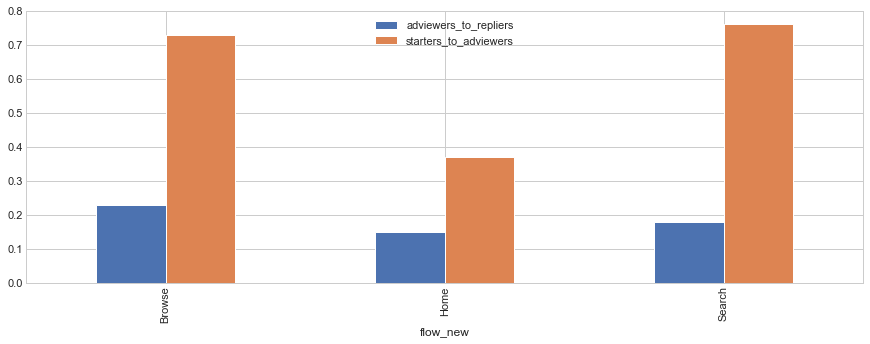

In [155]:
starters_to_dub['starters_to_adviewers'] = starters_to_dub['adviewers_new_users'] / starters_to_dub['starters_new_users']
starters_to_dub['adviewers_to_repliers'] = starters_to_dub['repliers_new_users'] / starters_to_dub['adviewers_new_users']
starters_to_dub.pivot_table(index='flow_new' , values=['adviewers_to_repliers' , 'starters_to_adviewers'] , aggfunc={'adviewers_to_repliers':'mean' ,'starters_to_adviewers':'mean'}).plot(kind='bar' , figsize=(15,5))

In [157]:
starters_to_dub.pivot_table(index='flow_new' , values=['adviewers_to_repliers' , 'starters_to_adviewers' , 'new_replier_to_starters_new'] , aggfunc={'adviewers_to_repliers':'mean' ,'starters_to_adviewers':'mean' , 'new_replier_to_starters_new':'mean'})

,adviewers_to_repliers,new_replier_to_starters_new,starters_to_adviewers
flow_new,,,
Browse,0.229118,0.167547,0.730302
Home,0.149221,0.055319,0.369271
Search,0.177652,0.136013,0.762809


# DUB / Starters of home,browse and search returning users

In [140]:
query = """

;drop table if exists new_users_label;
select
  date_nk,
  session_long
   into temp new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
and date_nk >= '2019-04-01'
 group by 1,2;


;drop table if exists returning_users_label;
select
  v.date_nk,
  v.session_long
   into temp table returning_users_label
   from ods.fact_user_hydra_browsing_activity v
     left join new_users_label t on v.session_long=t.session_long and v.date_nk=t.date_nk
 where
   is_panamera = true
    and v.date_nk >= '2019-04-01'
    and v.country_sk in ('olx|asia|in')
    and t.date_nk is null
group by 1,2
order by 2;

select
  a.date_nk,
  (case when search_string notnull then 'Search'
        when a.category_sk!='unknown' and search_string isnull then 'Browse'
        when a.category_sk='unknown' and search_string isnull  then 'Home'  end) as Flow_new,

  count(distinct a.session_long_sk) starters_new_users
, count(distinct case when a.num_ads_with_adviews>'0' then a.session_long_sk end) adviewers_new_users
, count(distinct case when ((a.num_ads_with_item_chat_tap_send_1st_reply+a.num_ads_with_item_chat_tap_send_offer)>'0')
                            or ((a.num_ads_with_item_tap_call)>'0')
                            then a.session_long_sk end) repliers_new_users

from ods.fact_resultset_performance a
  inner join returning_users_label f1 on f1.session_long=split_part(session_long_sk , '|' , 7) and f1.date_nk=a.date_nk
 where a.country_sk='olx|asia|in'
and a.date_nk >= '2019-04-01'
group by a.date_nk, Flow_new
order by 1;


"""

In [141]:
%%time
starters_to_dub_return = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 21min 22s


In [175]:
starters_to_dub_return.to_excel('C:\\Users\\OLX - Lucas Dresi\\Documents\\Activation\\activation_returning.xlsx')

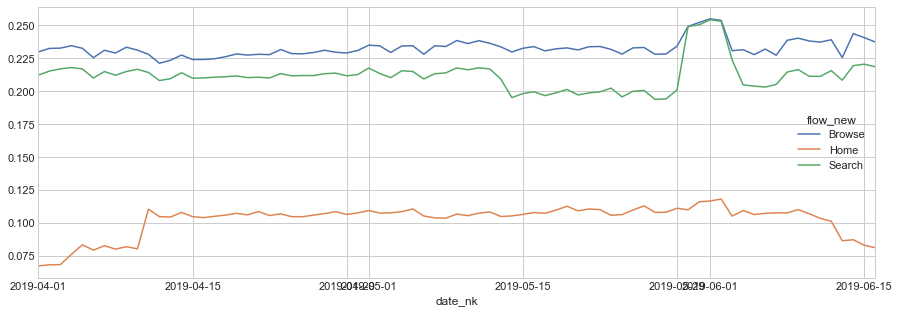

In [144]:
starters_to_dub_return['return_replier_to_starters_new'] = starters_to_dub_return['repliers_new_users'] / starters_to_dub_return['starters_new_users'] 
starters_to_dub_return.pivot_table(index='date_nk' , columns='flow_new' , values='return_replier_to_starters_new').plot(figsize=(15,5) , label='DUB / Starters of home,browse and search for returning users')

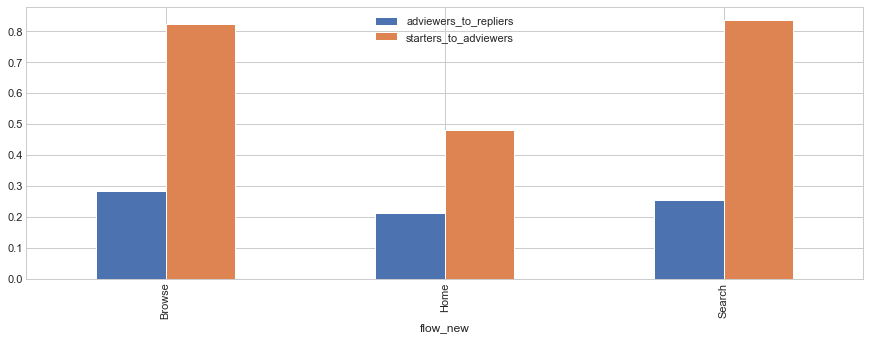

In [159]:
starters_to_dub_return['starters_to_adviewers'] = starters_to_dub_return['adviewers_new_users'] / starters_to_dub_return['starters_new_users']
starters_to_dub_return['adviewers_to_repliers'] = starters_to_dub_return['repliers_new_users'] / starters_to_dub_return['adviewers_new_users']
starters_to_dub_return.pivot_table(index='flow_new' , values=['adviewers_to_repliers' , 'starters_to_adviewers'] , aggfunc={'adviewers_to_repliers':'mean' ,'starters_to_adviewers':'mean'}).plot(kind='bar' , figsize=(15,5))

In [161]:
starters_to_dub_return.pivot_table(index='flow_new' , values=['adviewers_to_repliers' , 'starters_to_adviewers' , 'return_replier_to_starters_new'] , aggfunc={'adviewers_to_repliers':'mean' ,'starters_to_adviewers':'mean' , 'return_replier_to_starters_new':'mean'})

,adviewers_to_repliers,return_replier_to_starters_new,starters_to_adviewers
flow_new,,,
Browse,0.282983,0.232614,0.821915
Home,0.212548,0.102273,0.479541
Search,0.253075,0.211867,0.837008


# App install to onboarding to login complete to home

In [51]:
query = """

;drop table if exists app_install;
select
  session_long,
  date_event_nk
  into temp table app_install
   from ods.panameraolx_asia_hydra_ninja_android_last_month
  where
    trackevent like '%app_install%'
and session_long_seq = 1
group by 1,2

;drop table if exists onboarding_show;
select
  session_long,
  date_event_nk
  into temp table onboarding_show
   from ods.panameraolx_asia_hydra_ninja_android_last_month
  where
    trackevent like '%onboarding_show%'
 group by 1,2
 
;drop table if exists login_start;
select
  session_long,
  date_event_nk
  into temp table onboarding_show
   from ods.panameraolx_asia_hydra_ninja_android_last_month
  where
    trackevent like '%login_sign_in_start%'
 group by 1,2

;drop table if exists login_complete;
select
  session_long,
  date_event_nk
  into temp table login_complete
   from ods.panameraolx_asia_hydra_ninja_android_last_month
  where
    trackevent like '%login_sign_in_complete%'
 group by 1,2


;drop table if exists home;
select
  session_long,
  date_event_nk
  into temp table home
   from ods.panameraolx_asia_hydra_ninja_android_last_month
  where
    trackevent like '%view_listings%'
 group by 1,2;

;drop table if exists funnel_value_prop;
select
  a.session_long,
  a.date_event_nk,
  1 as app_open,
  case when b.session_long is not null then 1 else 0 end as onboarding_show,
  case when c.session_long is not null then 1 else 0 end as login_complete,
  case when d.session_long is not null then 1 else 0 end as home
  into temp table funnel_value_prop
   from app_install a
    left join onboarding_show b using (session_long,date_event_nk)
    left join login_complete c using (session_long,date_event_nk)
    left join home d using (session_long,date_event_nk);

select
  date_event_nk,
  sum(app_open) as app_open,
  sum(onboarding_show) as onboarding_show,
  sum(login_complete) as login_complete,
  sum(home) as home
  from funnel_value_prop
   where date_event_nk < '2019-05-24'
  group by 1


"""

In [52]:
%%time
prop_value = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 8min 17s


In [53]:
prop_value.head()

,date_event_nk,app_open,onboarding_show,login_complete,home
0,2019-05-19,196771,194403,179565,177742
1,2019-05-20,188721,186093,171479,170800
2,2019-05-02,189418,187053,170378,169578
3,2019-05-01,185993,183788,166989,166157
4,2019-05-10,182947,180549,164960,162789


In [ ]:
prop_value['appinstall_to_onboarding']

# Activation (MUL and MUB) / MAU

In [130]:
query = """


;drop table if exists mau;
select
  extract(month from date_nk) as month,
  session_long
  into temp mau
   from ods.fact_user_hydra_browsing_activity
 where is_panamera=true
 and country_sk='olx|asia|in'
 and extract(year from date_nk)=2019
  group by 1,2

;drop table if exists session_long_and_usersk;
select
  extract(month from date_nk) as month,
  session_long,
  user_sk
  into temp table session_long_and_usersk
     from ods.fact_user_hydra_browsing_activity
    where is_panamera = true
 and country_sk='olx|asia|in'
 and user_sk != 'unknown'
 and extract(year from date_nk)=2019
group by 1,2,3

;drop table if exists mau_with_user_sk;
select
  f1.month,
  f1.session_long,
  f2.user_sk
  into temp table mau_with_user_sk
  from mau f1
    left join session_long_and_usersk f2 on f1.session_long=f2.session_long and f1.month=f2.month
 order by 2,1

;drop table if exists mau_listers;
select
  extract(month from date_posted_nk) as month,
  user_sk
  into temp table mau_listers
 from ods.fact_listings
 where
    listing_net_sk like 'net%'
and country_sk='olx|asia|in'
and extract(year from date_posted_nk)=2019
group by 1,2

;drop table if exists mau_repliers;
select
  extract(month from date_sent_nk) as month,
  panamera_user_sk
 into temp mau_repliers
 from ods.fact_replies
where reply_num=1
  and country_sk='olx|asia|in'
  and extract(year from date_sent_nk)=2019
  and panamera_user_sk!='unknown'
group by 1,2

;drop table if exists mau_users;
select
  month,
  count(distinct session_long) as mau
   into temp mau_users
  from mau
  group by 1 order by 1

;drop table if exists activation_mau;
select
  a.month,
  count(distinct session_long) as activation_mau
  into temp table activation_mau
from mau_with_user_sk a
  inner join mau_listers b on a.user_sk=b.user_sk and a.month=b.month
  inner join mau_repliers c on a.user_sk=c.panamera_user_sk and a.month=b.month
group by 1;

select
  t.month,
  t.mau,
  b.activation_mau
   from mau_users t
  inner join activation_mau b on b.month=t.month

"""

In [135]:
%%time
activation_over_mau = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 6min 15s


In [136]:
activation_over_mau.head()

,month,mau,activation_mau
0,2,20079402,1481858
1,4,27613915,1776199
2,1,2544,209
3,3,27725567,1859414
4,6,17954401,785491


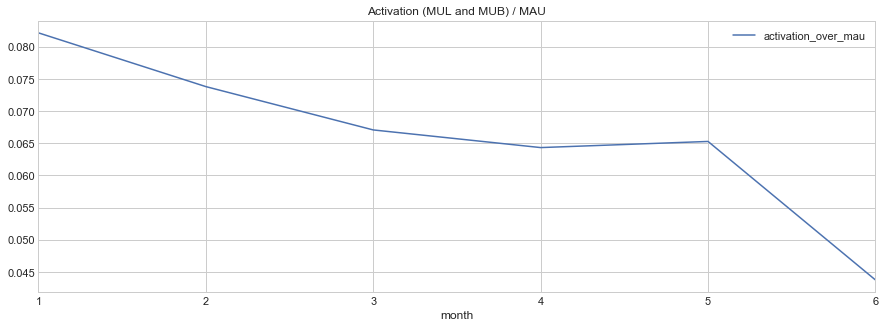

In [137]:
activation_over_mau['activation_over_mau'] = activation_over_mau['activation_mau'] / activation_over_mau['mau']
activation_over_mau = activation_over_mau.sort_values(['month'])
activation_over_mau = activation_over_mau.set_index('month')
activation_over_mau_plot = activation_over_mau[['activation_over_mau']]
activation_over_mau_plot.plot(title='Activation (MUL and MUB) / MAU' , figsize=(15,5))

# DUL (30 days) / DAU new

In [106]:
query = """

drop table if exists dau_new;
select
  date_nk,
  count(distinct session_long) as new_dau
   into temp table dau_new
   from ods.fact_user_hydra_browsing_activity
 where
   is_panamera = true
    and date_nk >= '2019-05-01'
    and country_sk in ('olx|asia|in')
    and user_active_new_returning_nk = 'new'
group by 1
order by 1

;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp table new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
 group by 1,2,3

;drop table if exists listingss;
select
   date_nk,
   count(distinct f1.user_sk) as new_user_post_30_days
  into temp table listingss
  from ods.fact_listings f1
    inner join new_users_label f2 on f1.user_sk=f2.user_sk
    where country_sk = 'olx|asia|in'
  and listing_net_sk like 'net%'
  and date_posted_nk >= '2019-05-01'
  and datediff(days ,date_nk,date_posted_nk) < 30
  group by 1;

select 
  b.date_nk,
  b.new_dau,
  a.new_user_post_30_days
  from dau_new b
   inner join listingss a on a.date_nk=b.date_nk
   

"""

In [107]:
%%time
df_news_to_post = pd.read_sql_query(query.replace('%', '%%'), engine)

Wall time: 3min 43s


In [110]:
df_news_to_post.head()

,date_nk,new_dau,new_user_post_30_days,DUL(30 days) / DAU new
0,2019-05-02,460631,40373,0.087647
1,2019-05-16,463352,48220,0.104068
2,2019-05-10,446982,43009,0.096221
3,2019-05-01,477561,40087,0.083941
4,2019-06-06,481600,42750,0.088767


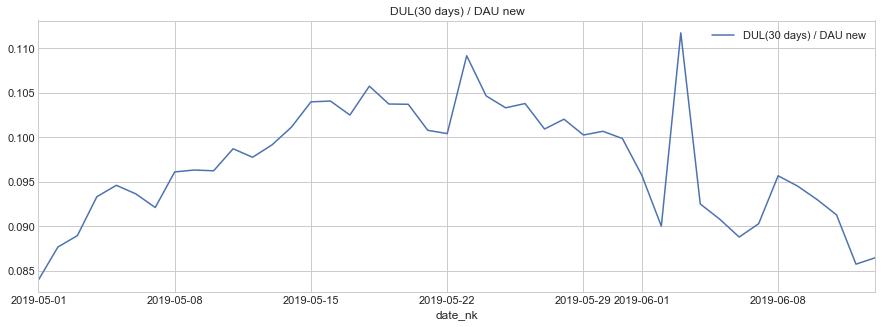

In [111]:
df_news_to_post['DUL(30 days) / DAU new'] = df_news_to_post['new_user_post_30_days'] / df_news_to_post['new_dau']
df_news_to_post = df_news_to_post.set_index('date_nk')
df_news_to_post_plot = df_news_to_post[['DUL(30 days) / DAU new']]
df_news_to_post_plot.plot(figsize=(15,5) , title='DUL(30 days) / DAU new')

# DUB (30 days) / DAU new

In [124]:
query = """

drop table if exists dau_new;
select
  date_nk,
  count(distinct session_long) as new_dau
   into temp table dau_new
   from ods.fact_user_hydra_browsing_activity
 where
   is_panamera = true
    and date_nk >= '2019-05-01'
    and country_sk in ('olx|asia|in')
    and user_active_new_returning_nk = 'new'
group by 1
order by 1

;drop table if exists new_users_label;
select
  date_nk,
  session_long,
  user_sk
   into temp table new_users_label
    from ods.fact_user_hydra_browsing_activity
  where
    is_panamera = true
and country_sk = 'olx|asia|in'
and user_active_new_returning_nk = 'new'
 group by 1,2,3

;drop table if exists repliess;
select
   date_nk,
   count(distinct f1.panamera_user_sk) as new_user_replies_30_days
  into temp table repliess
  from ods.fact_replies f1
    inner join new_users_label f2 on f1.panamera_user_sk=f2.user_sk
    where country_sk = 'olx|asia|in'
  and date_nk >= '2019-05-01'
  and reply_num = 1
  and datediff(days ,f2.date_nk,f1.date_sent_nk) < 30
  group by 1;

select 
  b.date_nk,
  b.new_dau,
  a.new_user_replies_30_days
  from dau_new b
   inner join repliess a on a.date_nk=b.date_nk
   

"""

In [127]:
%%time
df_news_to_reply_30_days = pd.read_sql_query(query.replace('%', '%%'), engine)

OperationalError: (psycopg2.extensions.QueryCanceledError) Query (34398321) canceled on user's request and ran out of wlm queues for restart.
 [SQL: "\n\ndrop table if exists dau_new;\nselect\n  date_nk,\n  count(distinct session_long) as new_dau\n   into temp table dau_new\n   from ods.fact_user_hydra_browsing_activity\n where\n   is_panamera = true\n    and date_nk >= '2019-05-01'\n    and country_sk in ('olx|asia|in')\n    and user_active_new_returning_nk = 'new'\ngroup by 1\norder by 1\n\n;drop table if exists new_users_label;\nselect\n  date_nk,\n  session_long,\n  user_sk\n   into temp table new_users_label\n    from ods.fact_user_hydra_browsing_activity\n  where\n    is_panamera = true\nand country_sk = 'olx|asia|in'\nand user_active_new_returning_nk = 'new'\n group by 1,2,3\n\n;drop table if exists repliess;\nselect\n   date_nk,\n   count(distinct f1.panamera_user_sk) as new_user_replies_30_days\n  into temp table repliess\n  from ods.fact_replies f1\n    inner join new_users_label f2 on f1.panamera_user_sk=f2.user_sk\n    where country_sk = 'olx|asia|in'\n  and date_nk >= '2019-05-01'\n  and reply_num = 1\n  and datediff(days ,f2.date_nk,f1.date_sent_nk) < 30\n  group by 1;\n\nselect \n  b.date_nk,\n  b.new_dau,\n  a.new_user_replies_30_days\n  from dau_new b\n   inner join repliess a on a.date_nk=b.date_nk\n   \n\n"] (Background on this error at: http://sqlalche.me/e/e3q8)

In [116]:
df_news_to_reply_30_days.head()

,date_nk,new_dau,new_user_replies_30_days
0,2019-05-05,460759,142413
1,2019-05-09,457695,141520
2,2019-05-14,467853,145599
3,2019-05-23,372638,117542
4,2019-06-12,497517,132658


In [ ]:
df_news_to_reply_30_days.head()

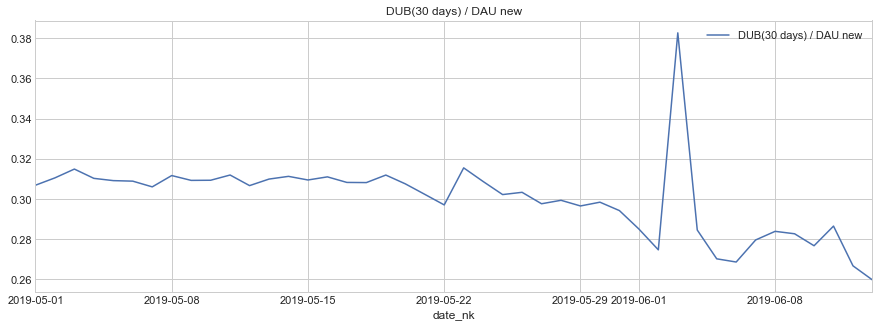

In [118]:
df_news_to_reply_30_days['DUB(30 days) / DAU new'] = df_news_to_reply_30_days['new_user_replies_30_days'] / df_news_to_reply_30_days['new_dau']
df_news_to_reply_30_days = df_news_to_reply_30_days.set_index('date_nk')
df_news_to_reply_30_days_plot = df_news_to_reply_30_days[['DUB(30 days) / DAU new']]
df_news_to_reply_30_days_plot.plot(figsize=(15,5) , title='DUB(30 days) / DAU new')